**Цель текущего ноутбука** - проанализировать эффективность различных подходов к решению поставленной задачи и на основе полученных результатов выбрать наилучший метод.

#  Библиотеки

In [1]:
# main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='darkgrid', palette='Paired', font_scale=1.2)

# preprocessing and engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

# models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline

# metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from time import time

# NLP: specific
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pymorphy2 import MorphAnalyzer
import string

# Данные

In [2]:
train = pd.read_csv('dataset/train.tsv', sep='\t')

train.tail()

,title,is_fake
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0
5754,Правительство застроит Россию нефтепродуктопро...,0
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1
5756,Туркмения в декабре начнет поставки газа в Китай,0
5757,Бывший тренер Локомотива возглавил нальчикский...,0


# Модели, параметры, инструменты


Для **извлечения признаков из текстовых данных** рассмотрим:  
- мешок слов (CountVectorizer)  
- мешок слов с масштабированием данных (TfidfVectorizer)

Для **токенизации текстов** сравним следующие методы:  
- обычное разбиение на токены (word_tokenizer)
- разбиение на токены + стэмминг (класс StemTokenizer)  
- разбиение на токены + лемматизация (класс LemmaTokenizer)

В качестве **алгоритмов машинного обучения** рассмотрим:
- Линейные модели (LogisticRegression, RidgeClassifier, SGDClassifier)
- Наивный Байес (MultinomialNB, BernoulliNB, ComplementNB)
- Ядерный метод опорных векторов (LinearSVC)
Каждая модель имеет параметр, регулирующий "сложность" модели (степень регуляризации/гладкости/...): alpha, C. Именно их и будем варьировать.

*Для поиска оптимальных параметров будем использовать решетчатый поиск с пятиблочной перекрестной проверкой.*


Все вышеперечисленные подходы будут сравниваться на одном и том же наборе данных, но с разной **предварительной обработкой**:  
- без очистки
- с удалением стоп-слов  
- с удалением пунктуационных знаков  
- с удалением пунктуационных знаков и удалением стоп-слов

In [3]:
# инструменты для выделения признаков
class StemTokenizer:
    def __init__(self):
        self.stemmer = SnowballStemmer(language='russian')
    def __call__(self, doc):
         return [self.stemmer.stem(t) for t in word_tokenize(doc)]

class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = MorphAnalyzer()
    def __call__(self, doc):
        return [self.lemmatizer.normal_forms(t)[0] for t in word_tokenize(doc)]
    
stemmer = StemTokenizer()
lemmatizer = LemmaTokenizer()

In [4]:
# варьирование параметров
parameters_C     = {'classifier__C': [0.001, 0.1, 1, 5, 10, 25, 50, 75, 100, 150],
                    'vectorizer__tokenizer': [word_tokenize, stemmer, lemmatizer]}

parameters_alpha = {'classifier__alpha': [0.00001, 0.001, 0.1, 0.2, 0.35, 0.4, 0.5, 1, 3, 5],
                    'vectorizer__tokenizer': [word_tokenize, stemmer, lemmatizer]}

parameters_bernoulli = {'classifier__alpha': [0.00001, 0.001, 0.1, 0.2, 0.35, 0.4, 0.5, 1, 3, 5],
                        'vectorizer__tokenizer': [word_tokenize, stemmer, lemmatizer],
                        'vectorizer__binary': [True]}

In [5]:
# модели и параметры
all_models = [LogisticRegression(max_iter=10000, solver='saga'),
              LogisticRegression(max_iter=10000, solver='newton-cg'),
              LinearSVC(),
              RidgeClassifier(),
              MultinomialNB(),
              ComplementNB(),
              BernoulliNB()]
all_parameters = [parameters_C,
                  parameters_C,
                  parameters_C,
                  parameters_alpha,
                  parameters_alpha,
                  parameters_alpha,
                  parameters_alpha,
                  parameters_bernoulli]

In [6]:
# инструменты для оценивания
def train_and_evaluate(model, vectorizer, parameters, X_train, X_valid,
                       y_train, y_valid):
    
    pipe = Pipeline(steps=[('vectorizer', vectorizer),
                           ('classifier', model)])
    grid = GridSearchCV(estimator=pipe,
                        param_grid=parameters,
                        cv=5)
    # train & predict
    grid.fit(X_train, y_train)
    start_predict = time()
    y_pred = grid.predict(X_valid)
    stop_predict = time()
    
    # quality
    precision = precision_score(y_pred, y_valid)
    recall = recall_score(y_pred, y_valid)
    f1 = f1_score(y_pred, y_valid)
    
    # visualization
    df = pd.DataFrame(grid.cv_results_)
    df['param_vectorizer__tokenizer'].replace([word_tokenize, lemmatizer, stemmer],
                                              ['Word tokenize', 'Lemmatization', 'Stemming'],
                                              inplace=True)
    df = df.rename(columns={'param_classifier__alpha': 'param_classifier',
                            'param_classifier__C':     'param_classifier'})
    sns.catplot(data=df, x='param_classifier', y='mean_test_score',
                hue='param_vectorizer__tokenizer', height=4, aspect=3, kind='point', legend=True)
    plt.title(repr(model))
    
    
    return [grid.best_params_, grid.best_score_, recall, precision, f1, stop_predict-start_predict]

## for comparison
def show_result(df_result):
    sns.catplot(data=df_result,
                y=df_result.index,
                x='F1',
                kind='boxen',
                orient="h",
                height=4, aspect=3)
    display(df_result)

In [7]:
# Итоговые результаты будем хранить здесь
full_results = pd.DataFrame(columns=['model', 'parameters', 'F1', 'preprocessing', 'time to predict'])

# Без очищения данных

In [8]:
texts = train.title.to_numpy()
targets = train.is_fake.to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(texts, targets, stratify=targets, random_state=19)

print(f'Количество примеров: {len(y_train)} / {len(y_valid)} (обучающий/валидационный)')
print(f'Распределение по классам: {np.bincount(y_train)} / {np.bincount(y_valid)} (обучающий/валидационный)')

Количество примеров: 4318 / 1440 (обучающий/валидационный)
Распределение по классам: [2159 2159] / [720 720] (обучающий/валидационный)


## Count Vectorizer

In [9]:
cnt_vect = CountVectorizer(token_pattern=None)

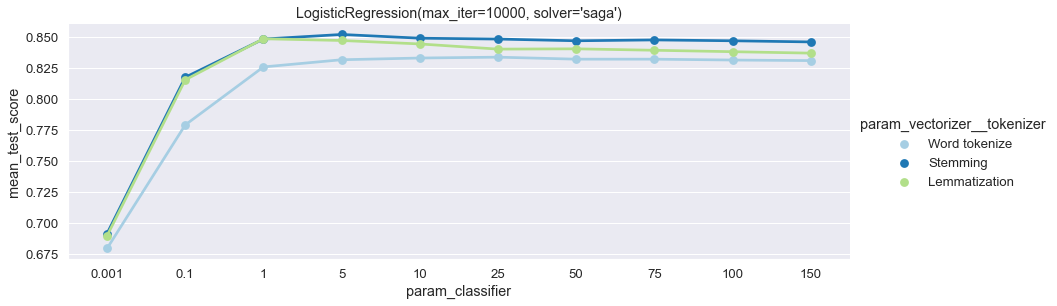

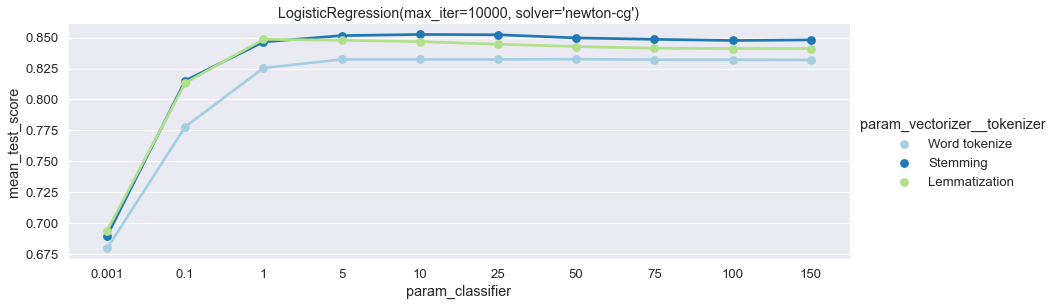

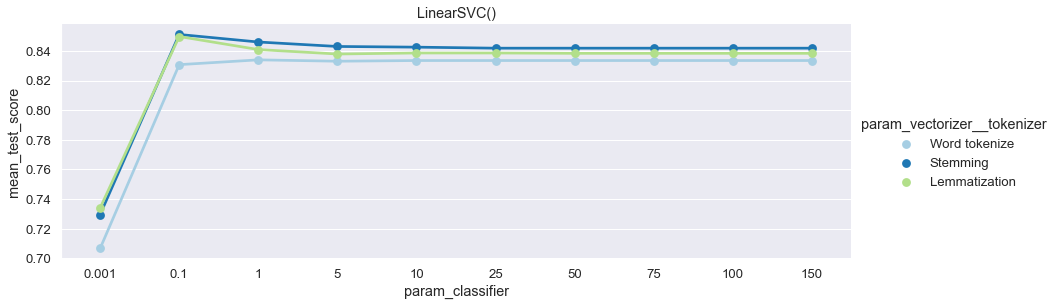

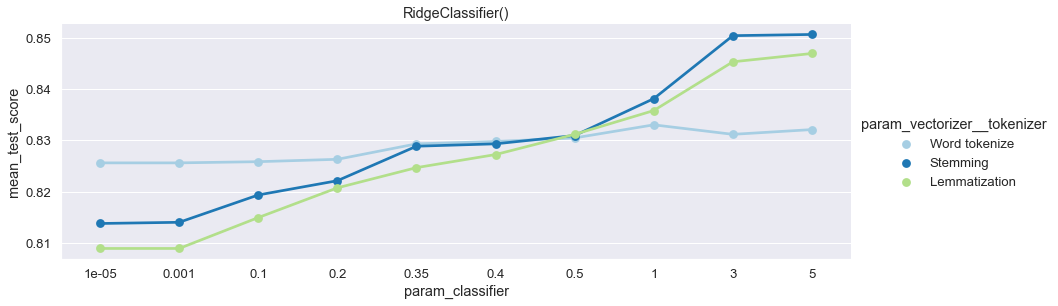

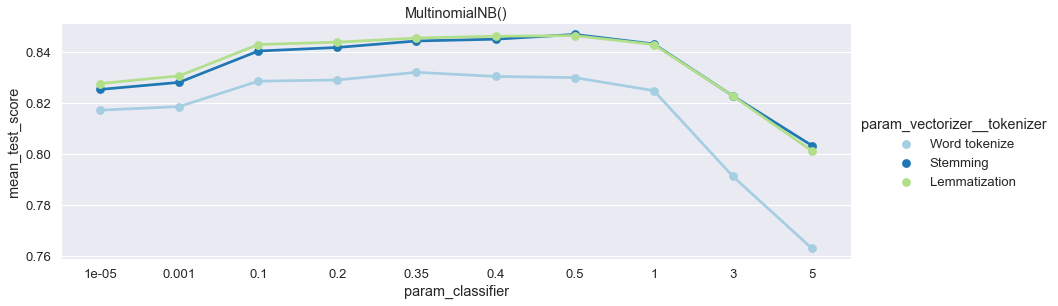

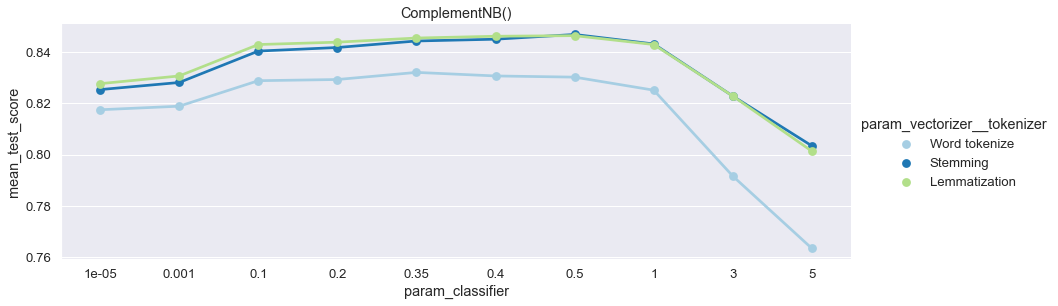

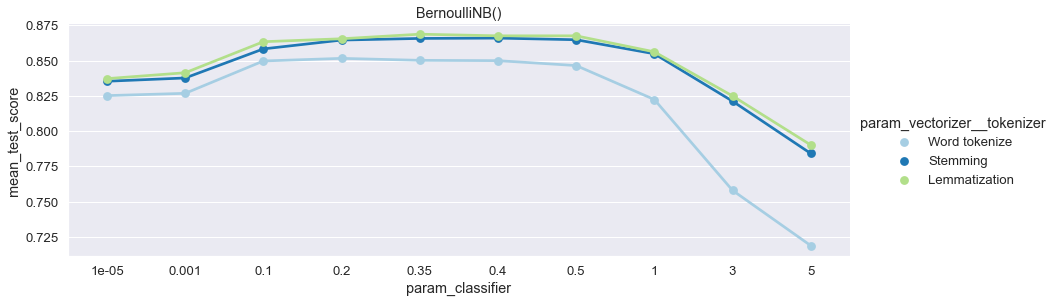

In [10]:
v1_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train, X_valid, y_train, y_valid)
    v1_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 5, 'vectorizer__tokenizer': ...",0.852248,0.900459,0.816667,0.856519,0.581426
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 10, 'vectorizer__tokenizer':...",0.85248,0.89771,0.816667,0.855273,0.678605
LinearSVC(),"{'classifier__C': 0.1, 'vectorizer__tokenizer'...",0.851088,0.906793,0.797222,0.848485,0.581095
RidgeClassifier(),"{'classifier__alpha': 5, 'vectorizer__tokenize...",0.850627,0.9088,0.788889,0.84461,0.654772
MultinomialNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.846916,0.824845,0.922222,0.87082,0.582806
ComplementNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.846916,0.824845,0.922222,0.87082,0.586254
BernoulliNB(),"{'classifier__alpha': 0.35, 'vectorizer__token...",0.868685,0.890173,0.855556,0.872521,2.321959


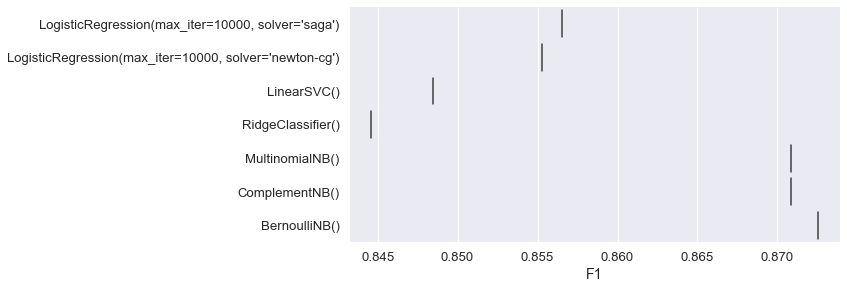

In [11]:
show_result(v1_result)

In [51]:
print('Mean F1 score = ', v1_result.F1.mean())
v1_result[v1_result.F1 == v1_result.F1.max()]

Mean F1 score =  0.8598637720536212


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.35, 'vectorizer__token...",0.868685,0.890173,0.855556,0.872521,2.321959


## TF-IDF

In [12]:
cnt_vect = TfidfVectorizer(token_pattern=None)

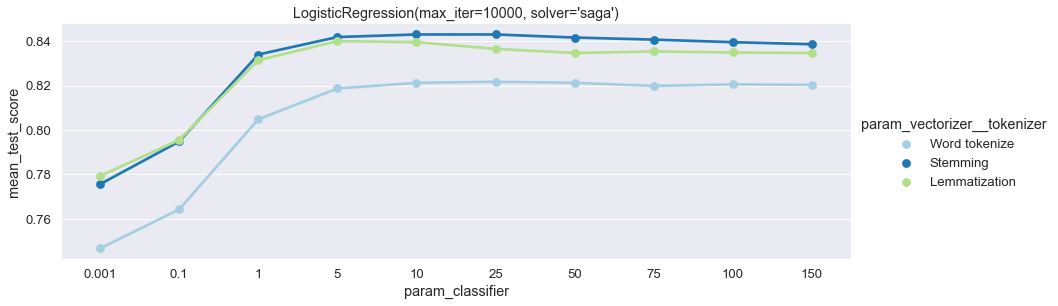

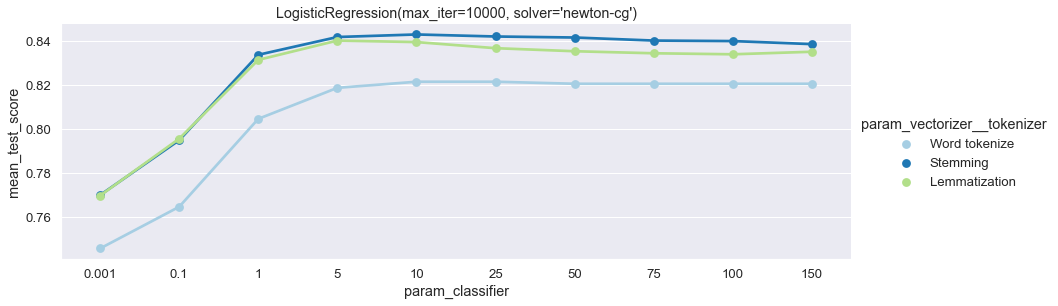

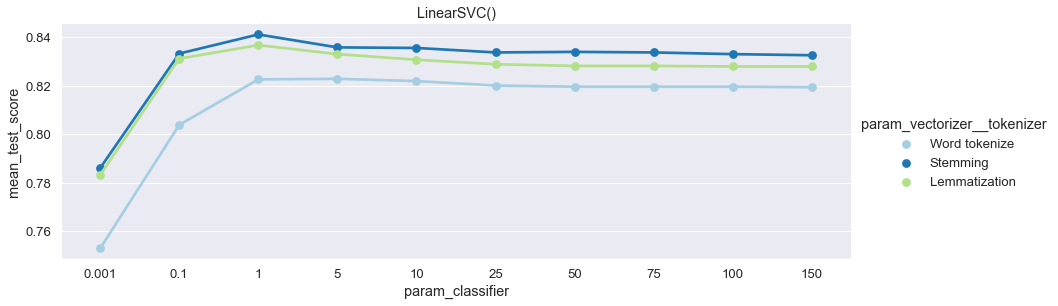

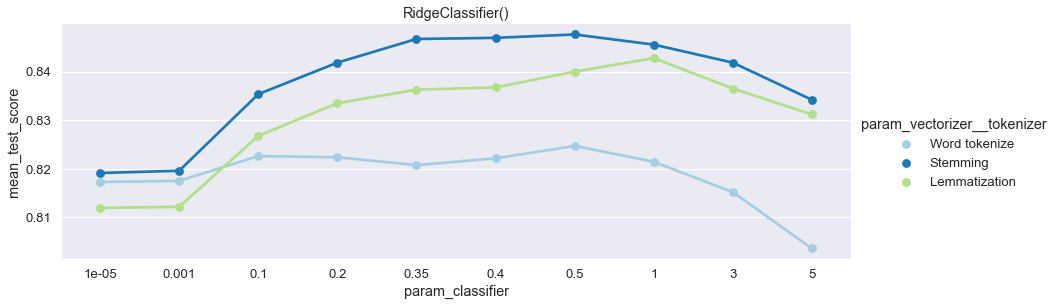

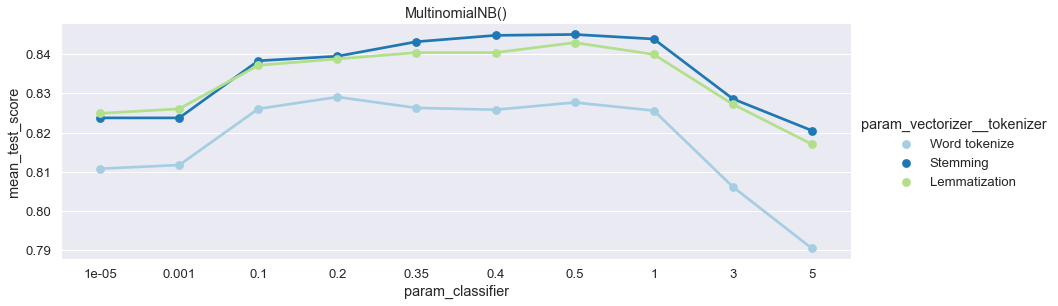

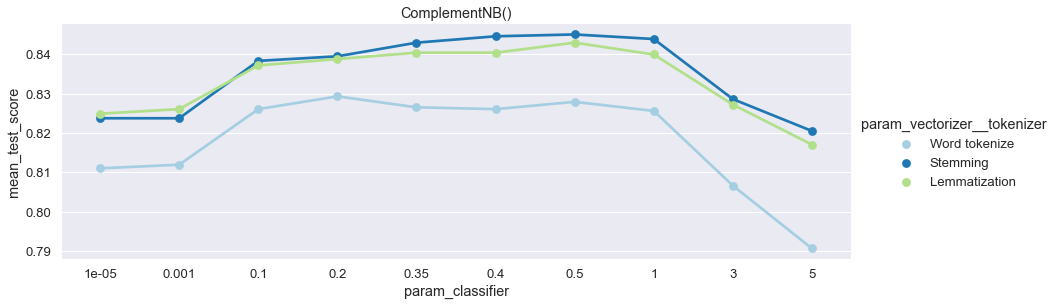

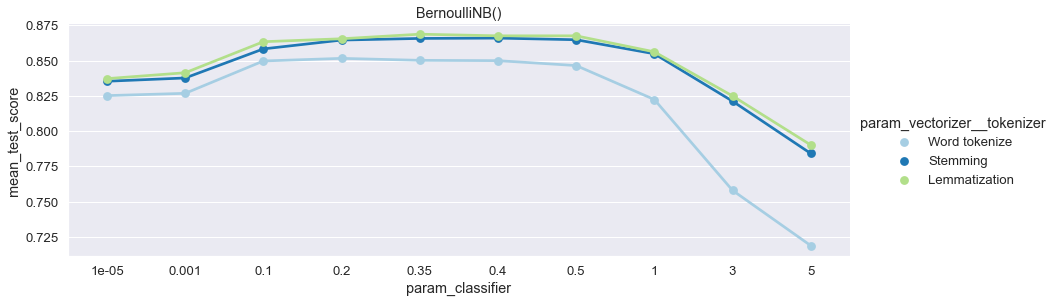

In [13]:
v2_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train, X_valid, y_train, y_valid)
    v2_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 10, 'vectorizer__tokenizer':...",0.842985,0.86676,0.858333,0.862526,0.582134
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 10, 'vectorizer__tokenizer':...",0.842985,0.86676,0.858333,0.862526,0.664037
LinearSVC(),"{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.841133,0.854772,0.858333,0.856549,0.585202
RidgeClassifier(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.847619,0.849862,0.856944,0.853389,0.661499
MultinomialNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.845062,0.816176,0.925,0.867188,0.595716
ComplementNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.845062,0.816176,0.925,0.867188,0.595871
BernoulliNB(),"{'classifier__alpha': 0.35, 'vectorizer__token...",0.868685,0.890173,0.855556,0.872521,2.343673


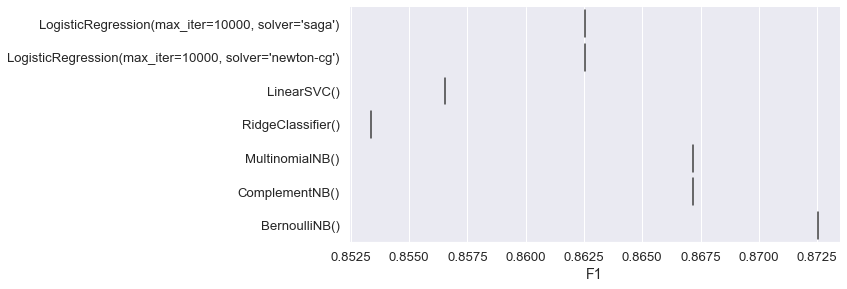

In [14]:
show_result(v2_result)

In [50]:
print('Mean F1 score = ', v2_result.F1.mean())
v2_result[v2_result.F1 == v2_result.F1.max()]

Mean F1 score =  0.8631265855898081


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.35, 'vectorizer__token...",0.868685,0.890173,0.855556,0.872521,2.343673


# After removing punctuation

In [15]:
punct_chars = string.punctuation + "«»"

def delete_punct(sentence):
    tokens = word_tokenize(sentence)
    result = []
    for t in tokens:
        if t in punct_chars:
            continue
        else:
            result.append(t)
    return ' '.join(result)

# без знаков пунктуации
train['no_punct'] = train.title.apply(delete_punct)
texts_no_punct = train.no_punct.to_numpy()

X_train_pnct, X_valid_pnct, y_train, y_valid = train_test_split(texts_no_punct, targets,
                                                                stratify=targets, random_state=19)

## Count Vectorizer

In [16]:
cnt_vect = CountVectorizer(token_pattern=None)

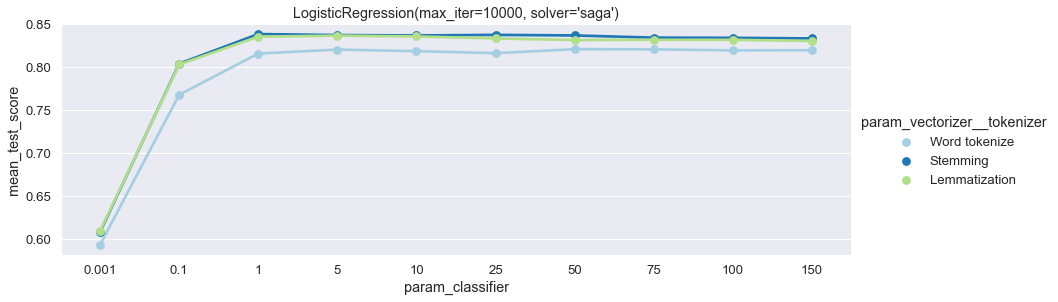

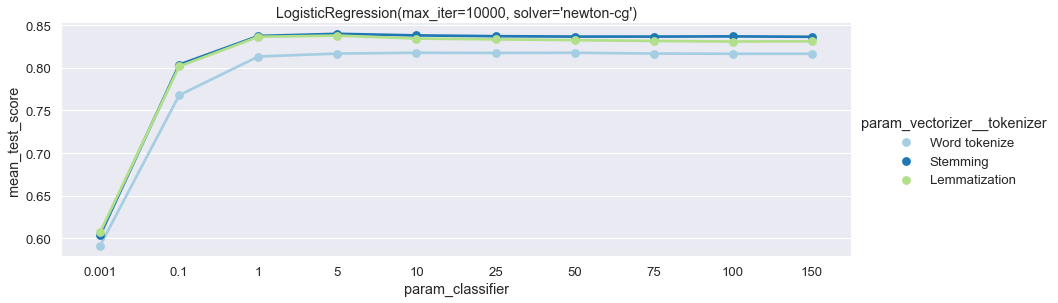

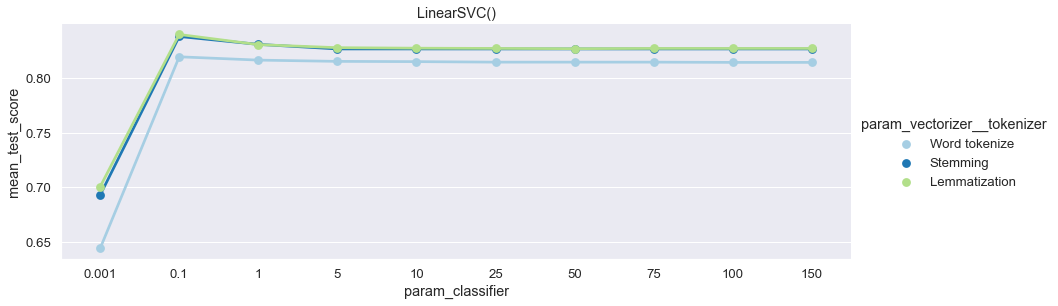

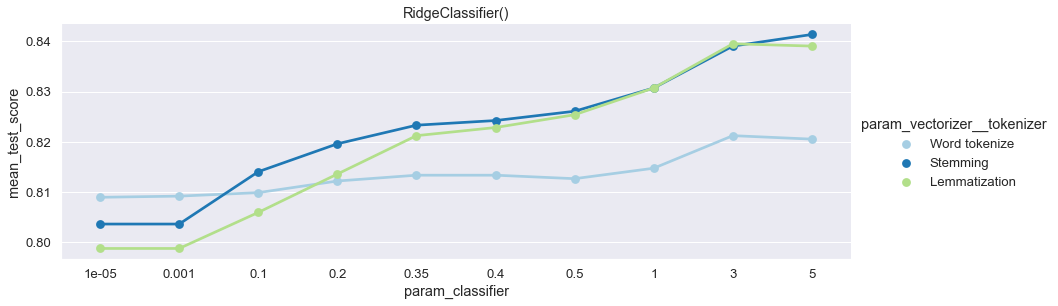

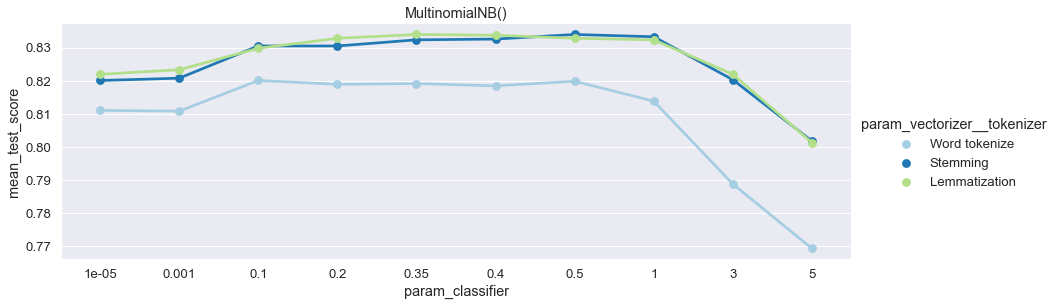

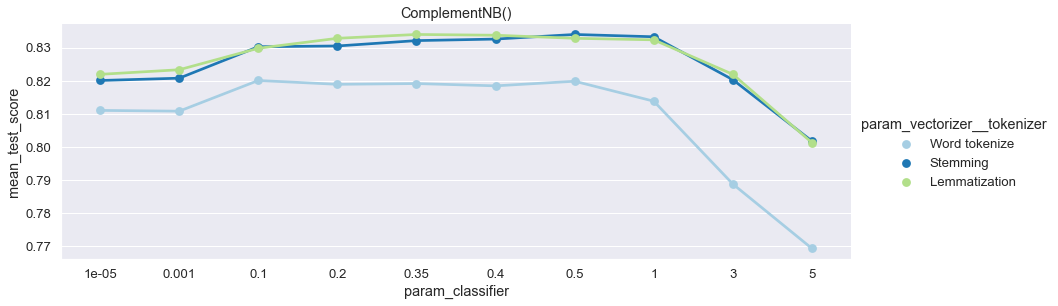

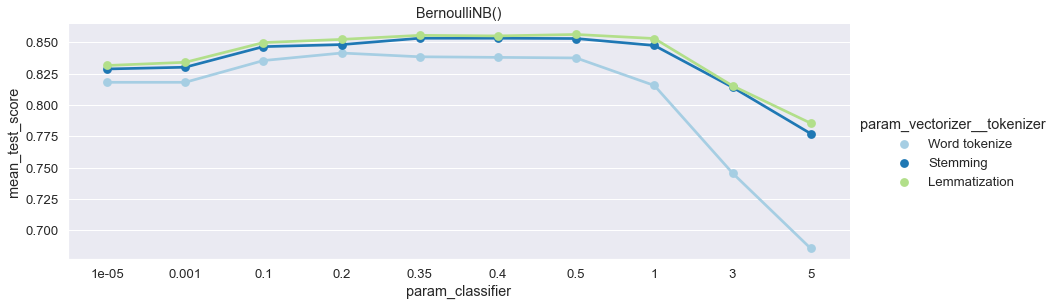

In [17]:
v3_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train_pnct, X_valid_pnct, y_train, y_valid)
    v3_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.838585,0.889752,0.795833,0.840176,0.596033
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 5, 'vectorizer__tokenizer': ...",0.839974,0.890823,0.781944,0.83284,0.689994
LinearSVC(),"{'classifier__C': 0.1, 'vectorizer__tokenizer'...",0.839511,0.89325,0.790278,0.838615,2.333586
RidgeClassifier(),"{'classifier__alpha': 5, 'vectorizer__tokenize...",0.841363,0.890823,0.781944,0.83284,0.652074
MultinomialNB(),"{'classifier__alpha': 0.35, 'vectorizer__token...",0.833948,0.815327,0.901389,0.856201,2.321021
ComplementNB(),"{'classifier__alpha': 0.35, 'vectorizer__token...",0.833948,0.815327,0.901389,0.856201,2.329428
BernoulliNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.85641,0.88712,0.851389,0.868887,2.324952


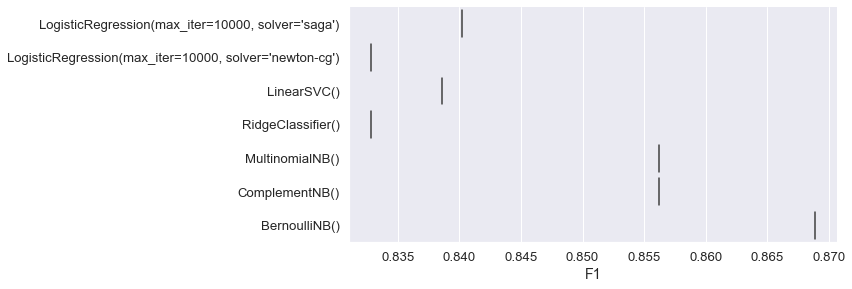

In [18]:
show_result(v3_result)

In [49]:
print('Mean F1 score = ', v3_result.F1.mean())
v3_result[v3_result.F1 == v3_result.F1.max()]

Mean F1 score =  0.8465370552617486


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.85641,0.88712,0.851389,0.868887,2.324952


## TF-IDF

In [19]:
cnt_vect = TfidfVectorizer(token_pattern=None)

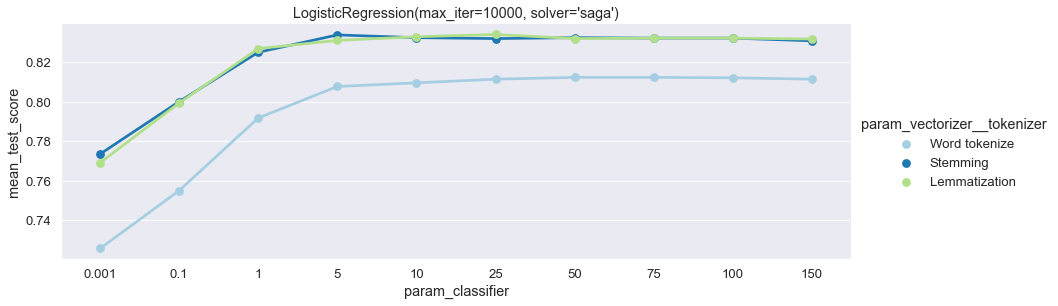

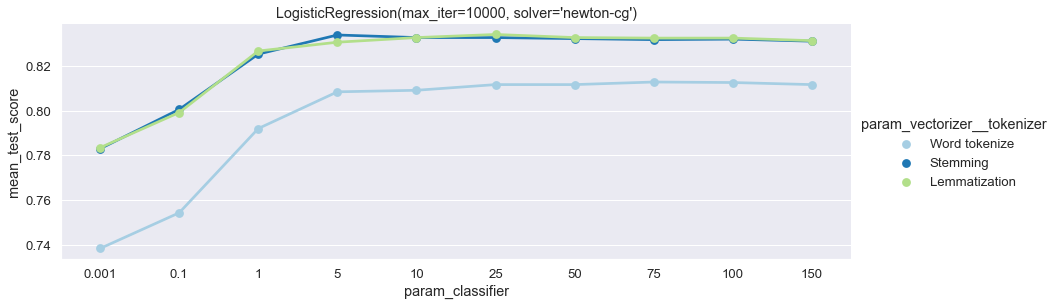

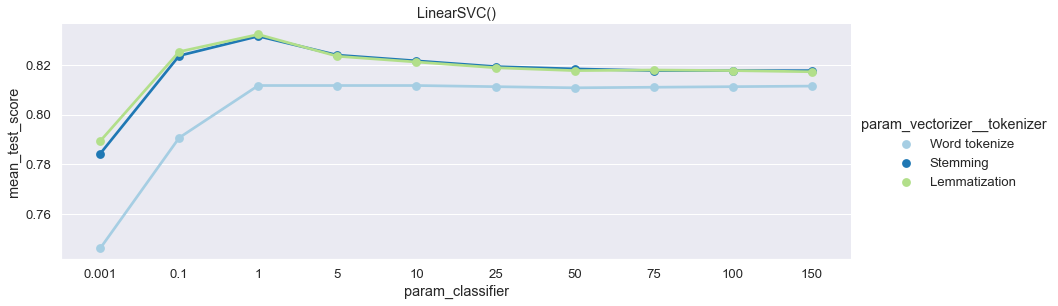

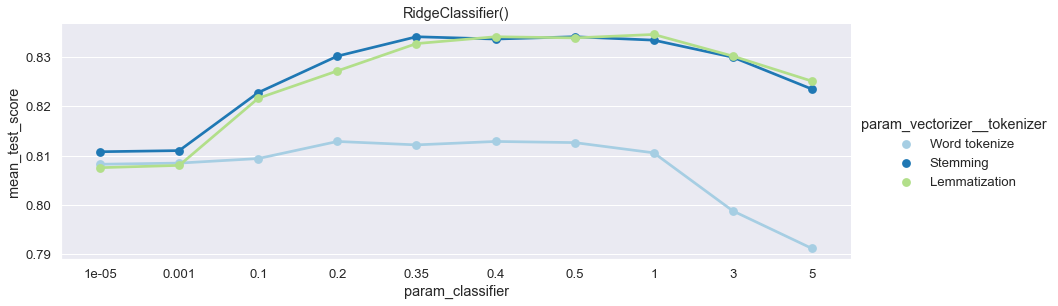

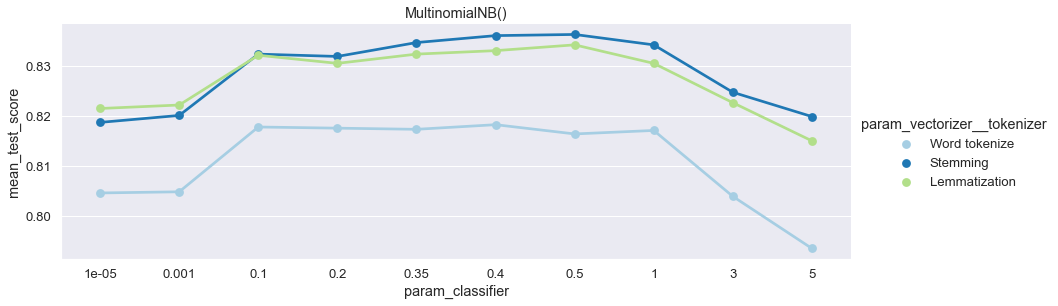

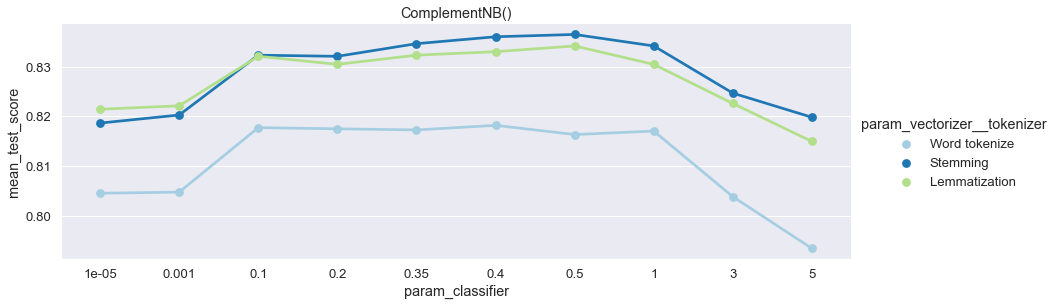

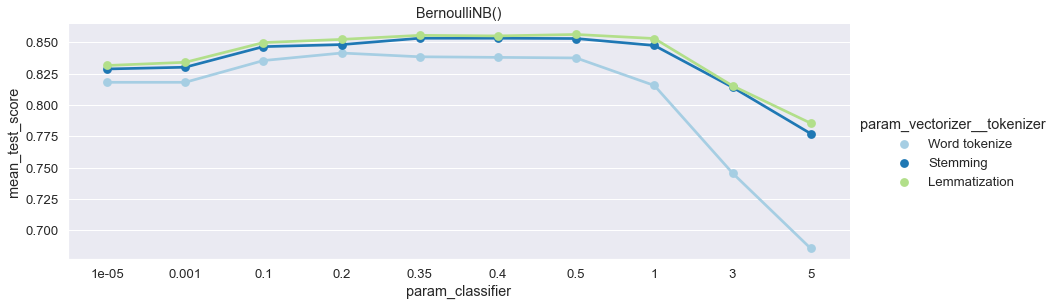

In [20]:
v4_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train_pnct, X_valid_pnct, y_train, y_valid)
    v4_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 25, 'vectorizer__tokenizer':...",0.834184,0.836,0.870833,0.853061,2.33461
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 25, 'vectorizer__tokenizer':...",0.834184,0.836,0.870833,0.853061,2.445948
LinearSVC(),"{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.832331,0.836707,0.861111,0.848734,2.317863
RidgeClassifier(),"{'classifier__alpha': 1, 'vectorizer__tokenize...",0.834648,0.848361,0.8625,0.855372,2.396423
MultinomialNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.83626,0.814586,0.915278,0.862001,0.591063
ComplementNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.836491,0.814586,0.915278,0.862001,0.612231
BernoulliNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.85641,0.88712,0.851389,0.868887,2.906474


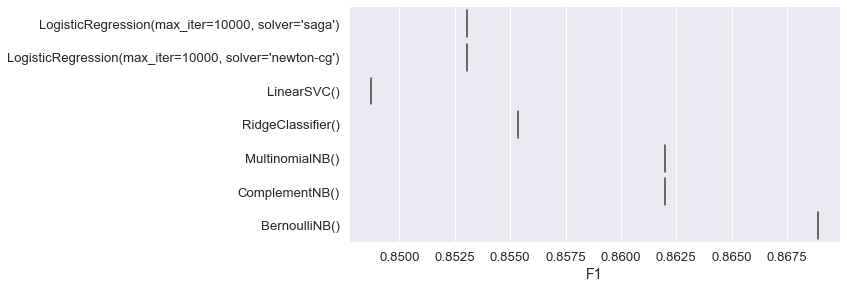

In [21]:
show_result(v4_result)

In [48]:
print('Mean F1 score = ', v4_result.F1.mean())
v4_result[v4_result.F1 == v4_result.F1.max()]

Mean F1 score =  0.8575882891239522


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.85641,0.88712,0.851389,0.868887,2.906474


# After removing stop-words

In [22]:
russian_stop_words = stopwords.words("russian")

def delete_stop(sentence):
    tokens = word_tokenize(sentence)
    result = []
    for t in tokens:
        if t in russian_stop_words:
            continue
        else:
            result.append(t)
    return ' '.join(result)

# без стоп-слов
train['no_stops'] = train.title.apply(delete_stop)
texts_no_stops = train.no_stops.to_numpy()

X_train_stop, X_valid_stop, y_train, y_valid = train_test_split(texts_no_stops, targets,
                                                                stratify=targets, random_state=19)

## Count Vectorizer

In [23]:
cnt_vect = CountVectorizer(token_pattern=None)

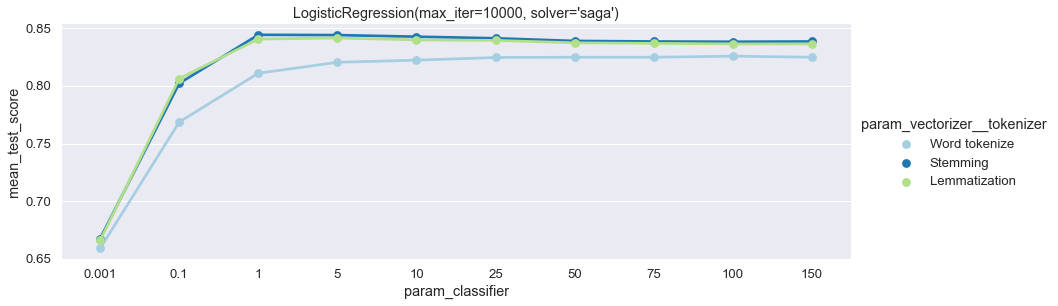

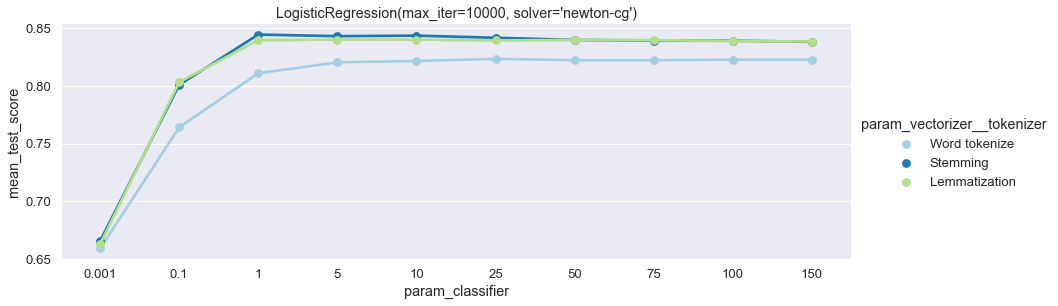

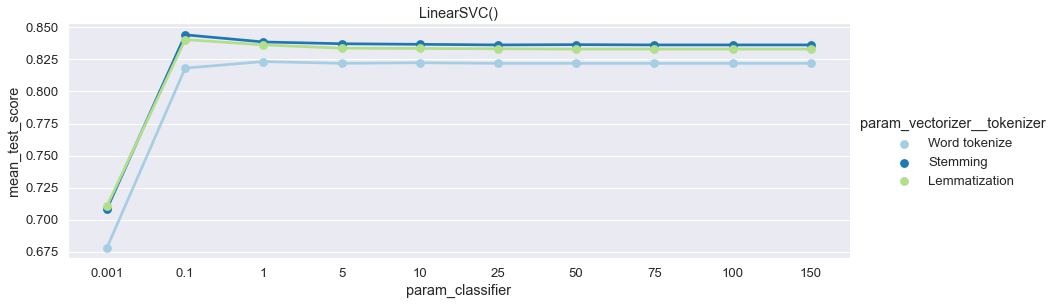

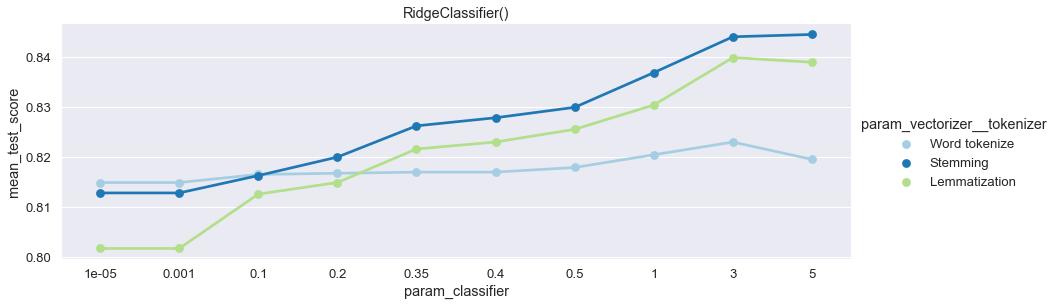

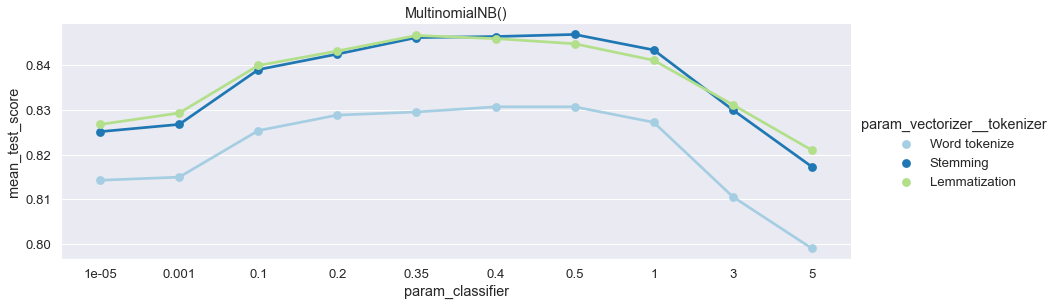

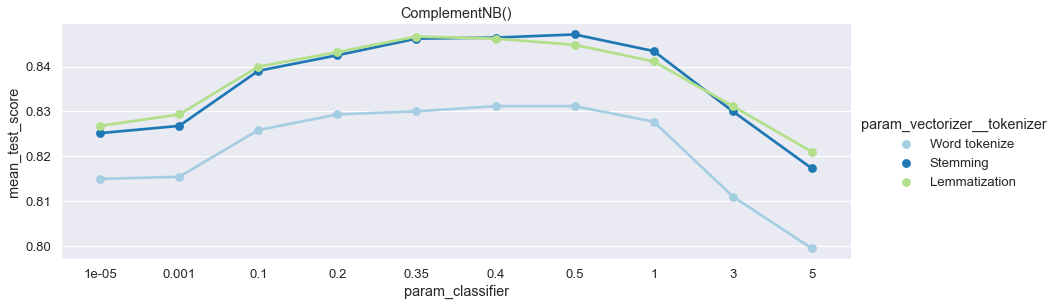

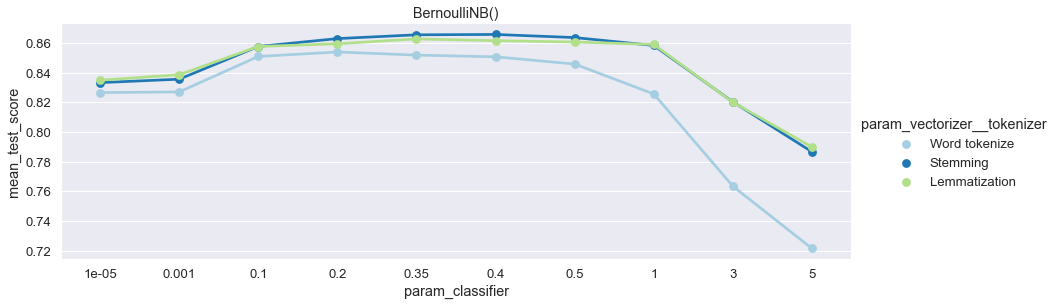

In [24]:
v5_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train_stop, X_valid_stop, y_train, y_valid)
    v5_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.844372,0.893584,0.793056,0.840324,0.523973
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.844603,0.894488,0.788889,0.838376,0.608998
LinearSVC(),"{'classifier__C': 0.1, 'vectorizer__tokenizer'...",0.84414,0.898754,0.801389,0.847283,0.512181
RidgeClassifier(),"{'classifier__alpha': 5, 'vectorizer__tokenize...",0.844604,0.897476,0.790278,0.840473,0.576187
MultinomialNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.846915,0.818408,0.913889,0.863517,0.524578
ComplementNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.847147,0.818408,0.913889,0.863517,0.531989
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.507475


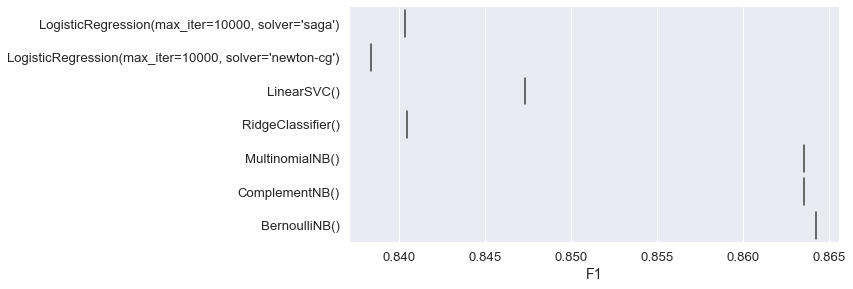

In [25]:
show_result(v5_result)

In [47]:
print('Mean F1 score = ', v5_result.F1.mean())
v5_result[v5_result.F1 == v5_result.F1.max()]

Mean F1 score =  0.8511057899960628


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.507475


## TF-IDF

In [26]:
cnt_vect = TfidfVectorizer(token_pattern=None)

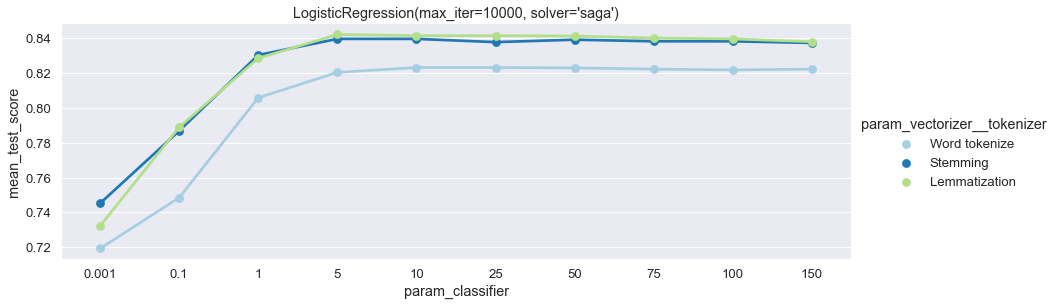

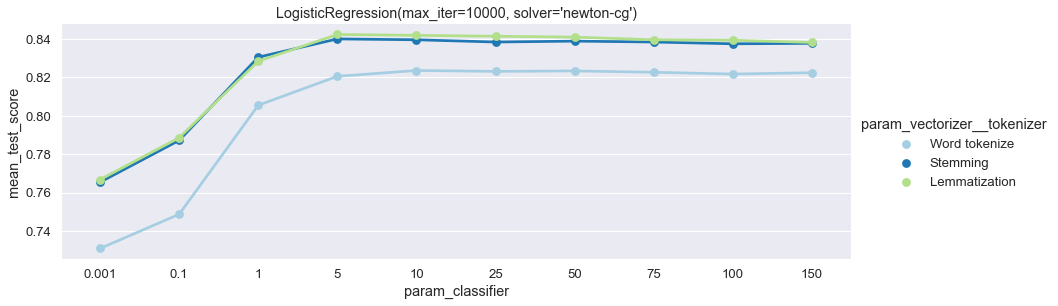

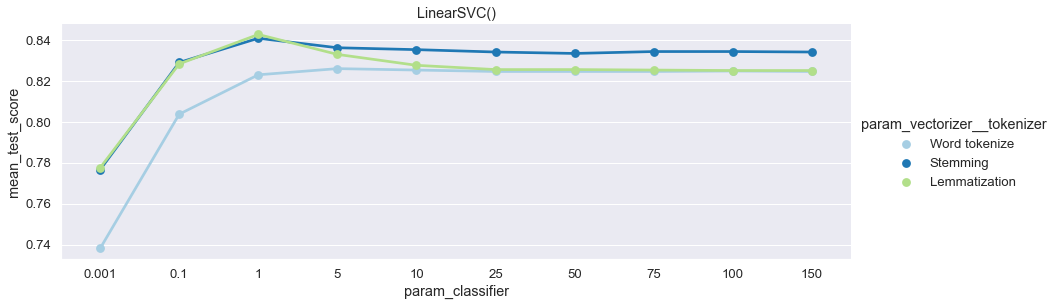

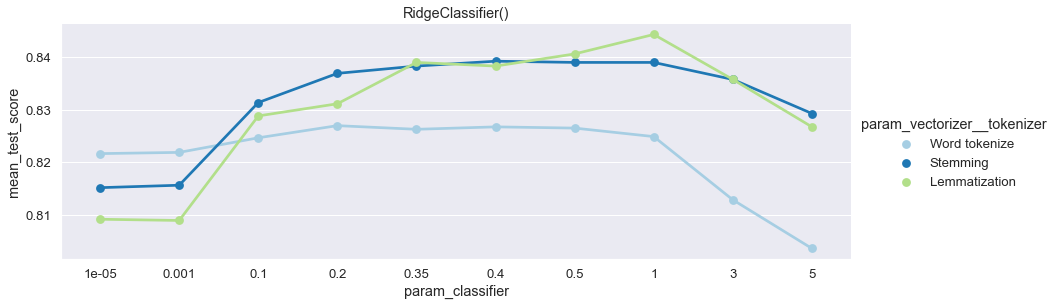

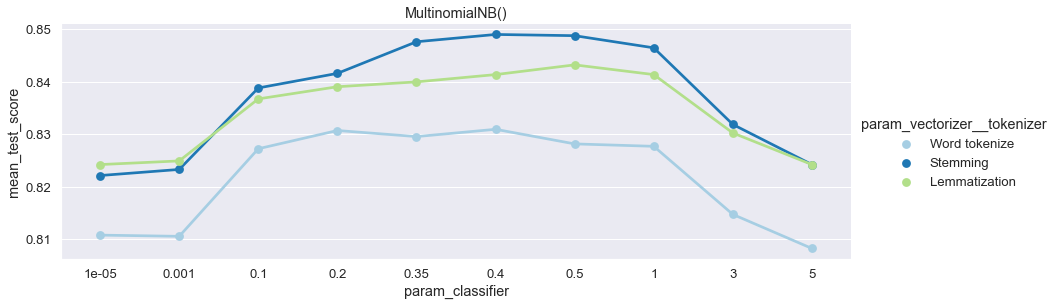

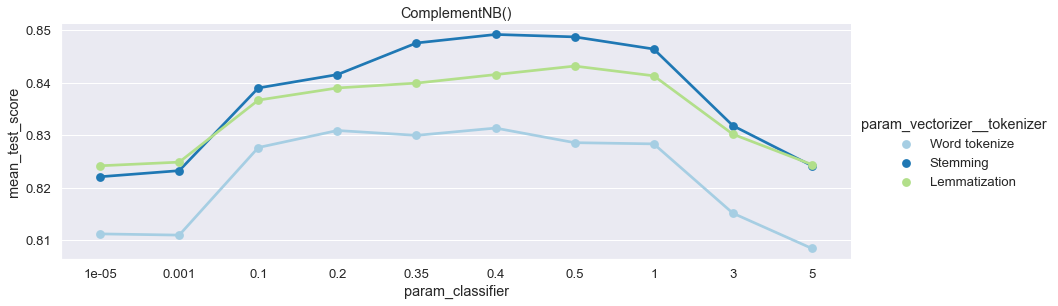

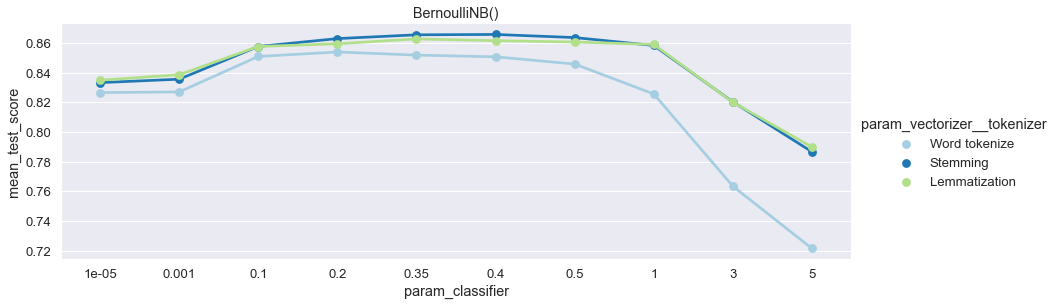

In [27]:
v6_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train_stop, X_valid_stop, y_train, y_valid)
    v6_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 5, 'vectorizer__tokenizer': ...",0.842289,0.861538,0.855556,0.858537,1.649132
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 5, 'vectorizer__tokenizer': ...",0.842289,0.861538,0.855556,0.858537,1.711203
LinearSVC(),"{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.842522,0.846365,0.856944,0.851622,1.605642
RidgeClassifier(),"{'classifier__alpha': 1, 'vectorizer__tokenize...",0.844374,0.851801,0.854167,0.852982,1.728524
MultinomialNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.848999,0.813038,0.918056,0.862361,0.537203
ComplementNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.849231,0.813038,0.918056,0.862361,0.496544
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.524945


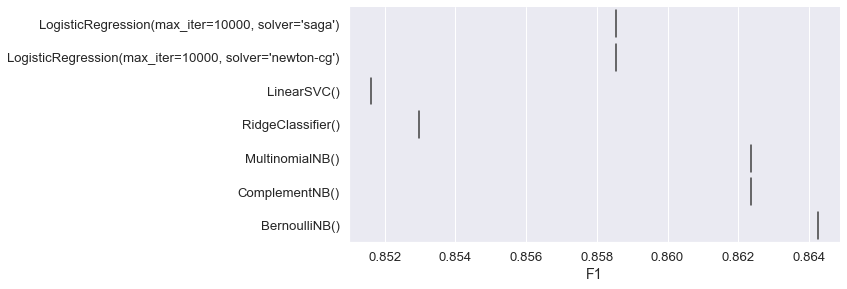

In [28]:
show_result(v6_result)

In [46]:
print('Mean F1 score = ', v6_result.F1.mean())
v6_result[v6_result.F1 == v6_result.F1.max()]

Mean F1 score =  0.8586642702662497


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.524945


# Removing punctuation and stop-words

In [29]:
# без стоп-слов и знаков пунктуации
train['no_stops_no_punct'] = train['no_stops'].apply(delete_punct)
texts_no_stops_punct = train['no_stops_no_punct'].to_numpy()

X_train_stop_punct, X_valid_stop_punct, y_train, y_valid = train_test_split(texts_no_stops_punct, targets,
                                                                stratify=targets, random_state=19)

## CountVectorizer

In [30]:
cnt_vect = CountVectorizer(token_pattern=None)

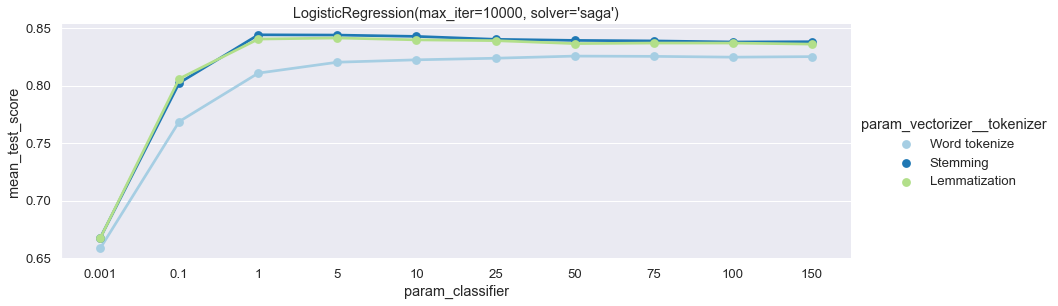

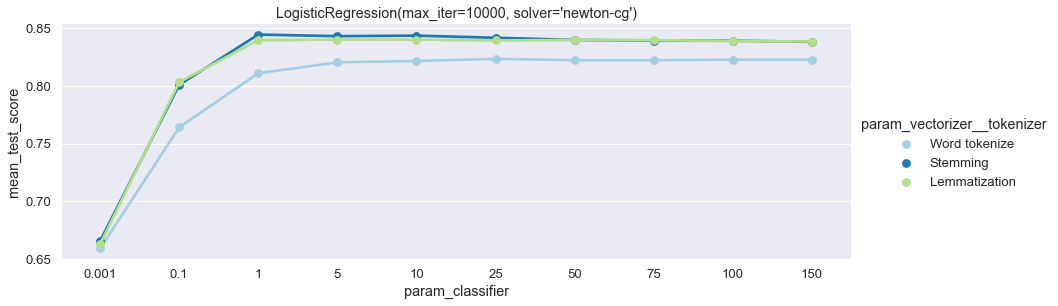

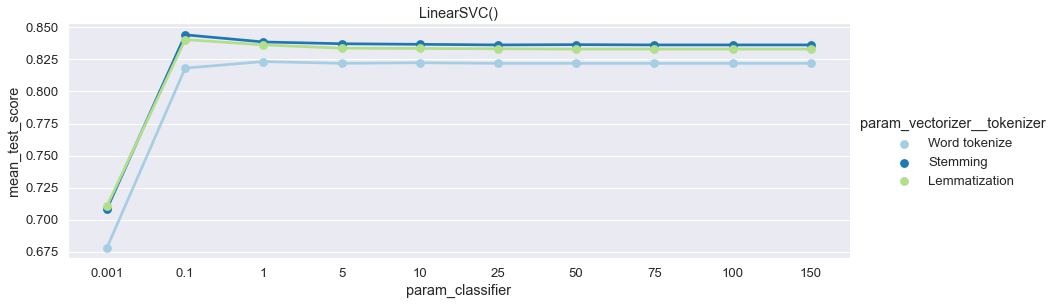

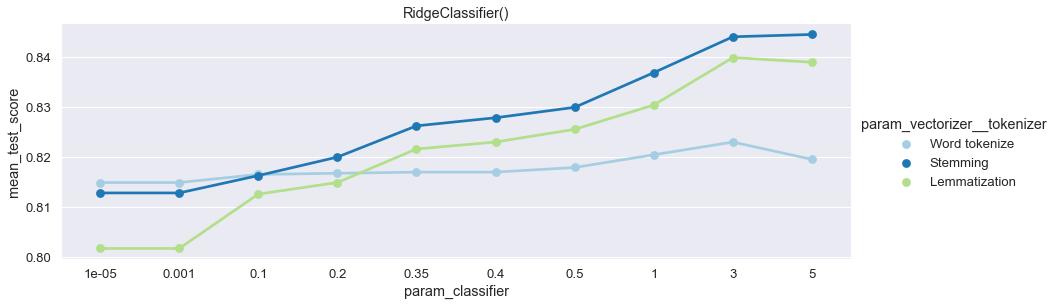

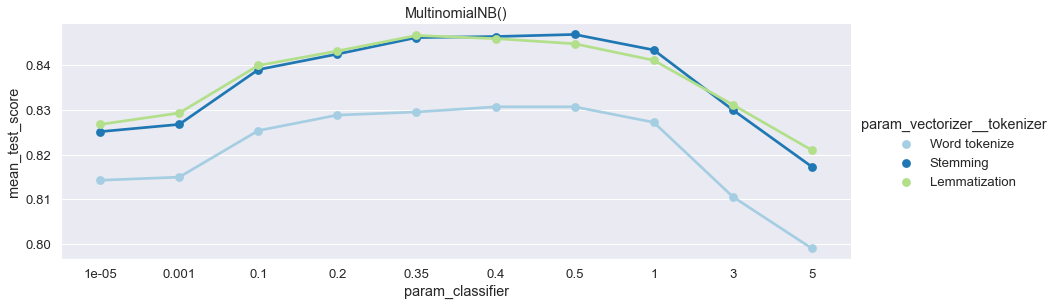

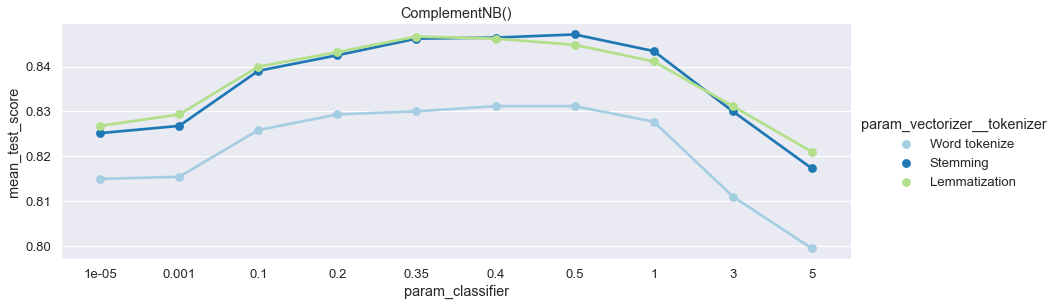

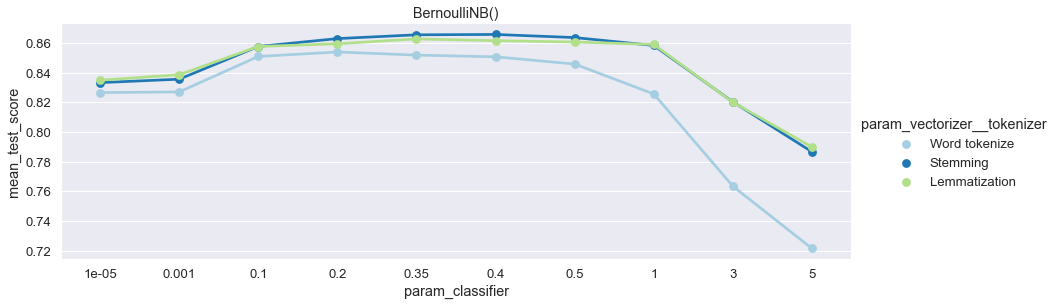

In [31]:
v7_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train_stop, X_valid_stop, y_train, y_valid)
    v7_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.844372,0.893584,0.793056,0.840324,0.518148
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.844603,0.894488,0.788889,0.838376,0.599888
LinearSVC(),"{'classifier__C': 0.1, 'vectorizer__tokenizer'...",0.84414,0.898754,0.801389,0.847283,0.503747
RidgeClassifier(),"{'classifier__alpha': 5, 'vectorizer__tokenize...",0.844604,0.897476,0.790278,0.840473,0.574196
MultinomialNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.846915,0.818408,0.913889,0.863517,0.527243
ComplementNB(),"{'classifier__alpha': 0.5, 'vectorizer__tokeni...",0.847147,0.818408,0.913889,0.863517,0.524429
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.516117


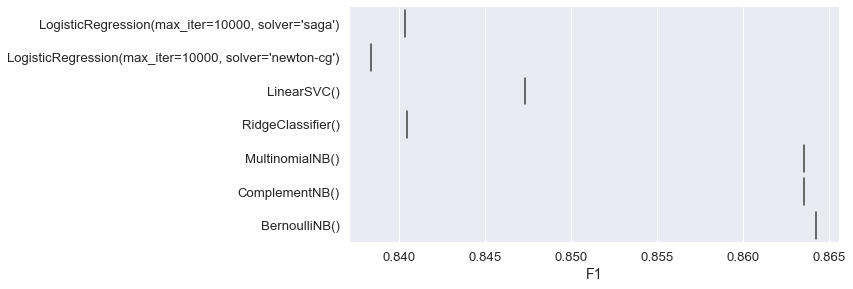

In [32]:
show_result(v7_result)

In [44]:
print('Mean F1 score = ', v7_result.F1.mean())
v7_result[v7_result.F1 == v7_result.F1.max()]

Mean F1 score =  0.8511057899960628


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.516117


## TF-IDF

In [33]:
cnt_vect = TfidfVectorizer(token_pattern=None)

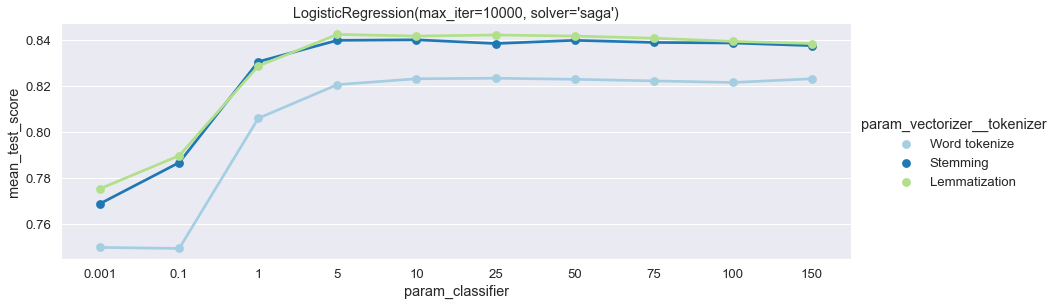

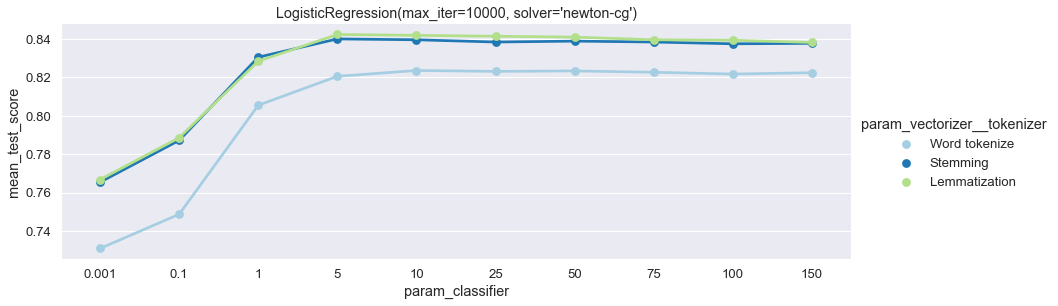

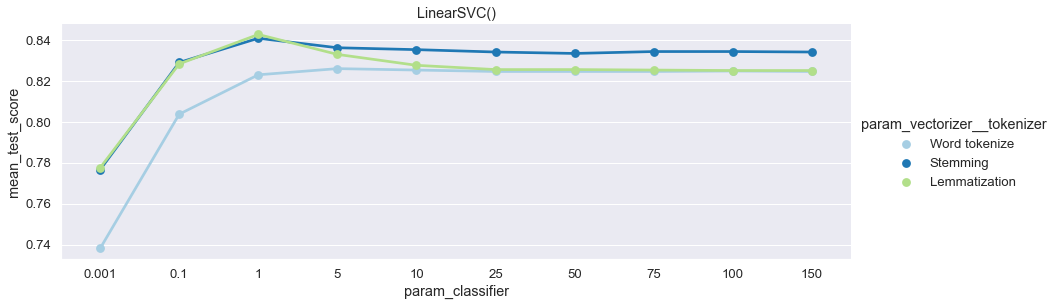

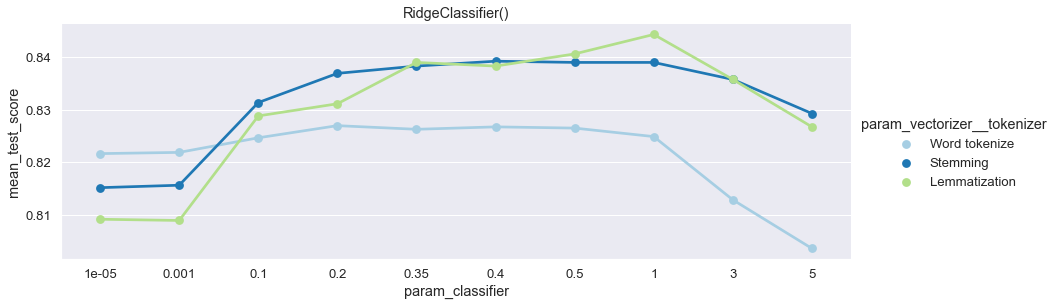

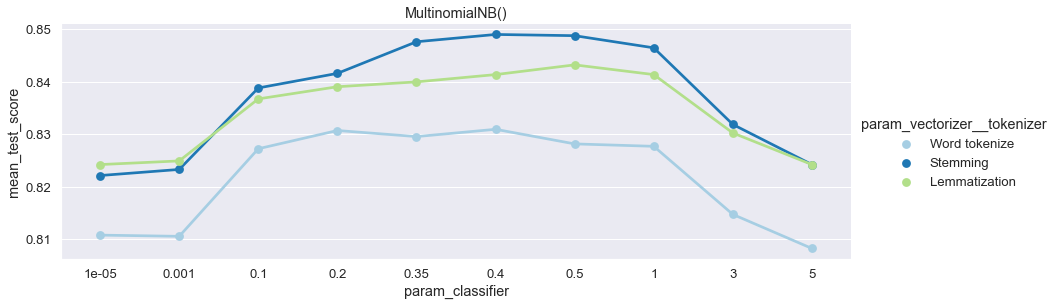

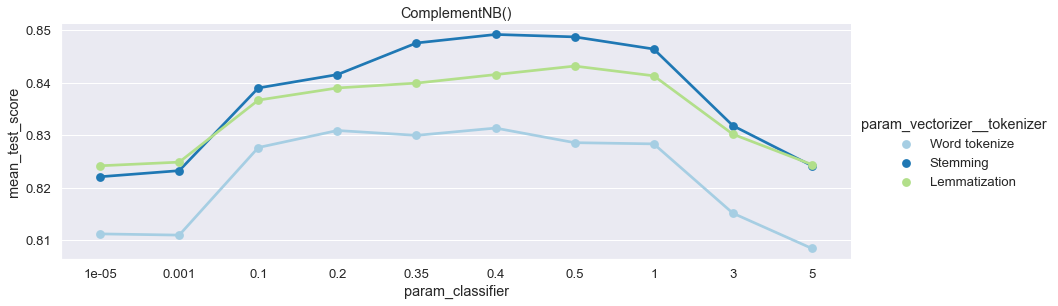

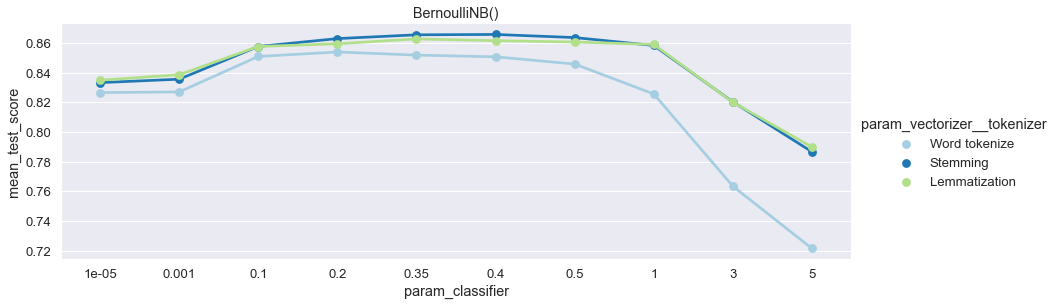

In [34]:
v8_result = pd.DataFrame(index = [repr(model) for model in all_models],
                         columns = ['best_params', 'score', 'recall', 'precision', 'F1', 'time for predict'])

for model, params in zip(all_models, all_parameters):
    best_p, score, recall, precision, f1, predict_time = train_and_evaluate(model, cnt_vect, params,
                                                                            X_train_stop, X_valid_stop, y_train, y_valid)
    v8_result.loc[repr(model)] = [best_p, score, recall, precision, f1, predict_time]

,best_params,score,recall,precision,F1,time for predict
"LogisticRegression(max_iter=10000, solver='saga')","{'classifier__C': 5, 'vectorizer__tokenizer': ...",0.842289,0.861538,0.855556,0.858537,1.615346
"LogisticRegression(max_iter=10000, solver='newton-cg')","{'classifier__C': 5, 'vectorizer__tokenizer': ...",0.842289,0.861538,0.855556,0.858537,1.665795
LinearSVC(),"{'classifier__C': 1, 'vectorizer__tokenizer': ...",0.842522,0.846365,0.856944,0.851622,1.603927
RidgeClassifier(),"{'classifier__alpha': 1, 'vectorizer__tokenize...",0.844374,0.851801,0.854167,0.852982,1.654078
MultinomialNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.848999,0.813038,0.918056,0.862361,0.510375
ComplementNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.849231,0.813038,0.918056,0.862361,0.500907
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.51499


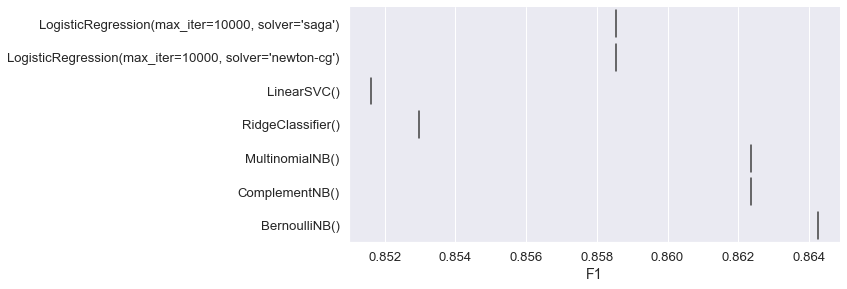

In [35]:
show_result(v8_result)

In [45]:
print('Mean F1 score = ', v8_result.F1.mean())
v8_result[v8_result.F1 == v8_result.F1.max()]

Mean F1 score =  0.8586642702662497


,best_params,score,recall,precision,F1,time for predict
BernoulliNB(),"{'classifier__alpha': 0.4, 'vectorizer__tokeni...",0.865673,0.885007,0.844444,0.86425,0.51499


# Подведение итогов
Наилучшим образом себя показывает модель BernoulliNB (в целом наблюдается преимущество моделей *наивного Байеса* в смысле метрики F1). Наиболее предпочтительными этапами предобработки данных являются:  
- Использование CountVectorizer для извлечения признаков из корпуса  
- Использование LemmaTokenizer (лемматизации) для токенизации текста  


Кроме того, оптимальное значение параметра aplha = 0.35

In [54]:
v1_result.loc['BernoulliNB()'].best_params

{'classifier__alpha': 0.35,
 'vectorizer__tokenizer': <__main__.LemmaTokenizer at 0x27a3b6d7a90>}